In [1]:
# Standard Packages
from torch.utils.data import random_split, DataLoader
import torch
import wandb
from datetime import datetime
from matplotlib import pyplot as plt
# Custom Packages
from NeuralNetworkModels.SimpleFeedForward import DirectFeedForwardNet
from AntennaDatasets import AntennaDatasetLoaders

# General Settings
torch.manual_seed(42) # Manual seed for sanity
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


wandb.init(project="my-test-project", entity="skoogy_dan")


wandb: Currently logged in as: skoogy_dan (use `wandb login --relogin` to force relogin)


In [2]:
CUTS_IN_DATASET = 4

dataset = AntennaDatasetLoaders.ReflectorCutDataset(cuts = CUTS_IN_DATASET,flatten_output = True)
print(dataset.antenna_parameters.shape)

(4, 4)


In [3]:
TEST_TRAIN_RATIO = 0.7
BATCH_SIZE = 1
train_len = int(len(dataset)*TEST_TRAIN_RATIO)
train_set, test_set = random_split(dataset, [train_len, len(dataset) - train_len])

train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=True)

In [4]:

#Define model
model = DirectFeedForwardNet(in_features = 3,out_features = 4004,NN = 10)
#Test Forward pass
print(model(torch.randn(2,3).to(device)))

tensor([[-0.2152,  0.2801, -0.0478,  ..., -0.1290,  0.0782, -0.1980],
        [-0.0999,  0.5365, -0.0406,  ..., -0.2524,  0.0116, -0.0440]],
       grad_fn=<AddmmBackward>)


In [5]:
LEARNING_RATE = 4e-2

criterion = torch.nn.MSELoss()

In [6]:
EPOCHS = int(200)
wandb.config = {
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "dataset_cuts": CUTS_IN_DATASET
}



# Optional

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

startTime = datetime.now()
train_loss_array = []
test_loss_array = []
loss_array = []

for epoch in range(EPOCHS):

    epoch_training_loss = 0
    epoch_training_targets = 0
    train_batches = 0
    for input_train_batch, target_train_batch in train_dataloader:
        
        ## Transfer Batch to Device
        input_train_batch = input_train_batch.to(device)
        target_train_batch = target_train_batch.to(device)
        
        prediction = model(input_train_batch)
        
        loss = criterion(input = prediction, target = target_train_batch)
        epoch_training_loss += loss/(target_train_batch.shape[0]*target_train_batch.shape[1])
        train_batches +=1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    
    epoch_test_loss = 0
    epoch_test_targets = 0
    test_batches=0
    with torch.no_grad():
        
        for input_test_batch, target_test_batch in test_dataloader:
            
            # Put thing to device
            input_test_batch = input_test_batch.to(device)
            target_test_batch = target_test_batch.to(device)
            
            
            prediction = model(input_train_batch)
            loss = criterion(input = prediction, target = target_test_batch)
            epoch_test_loss += loss/(target_test_batch.shape[0]*target_test_batch.shape[1])
            test_batches += 1
    
    if epoch%(EPOCHS/10) == 0:
        print('Training Loss',(epoch_training_loss/train_batches).item())
        print('Test Loss',(epoch_test_loss/test_batches).item())
    
    wandb.log({"Training Loss": epoch_training_loss.item(),
               "Test Loss" : epoch_test_loss.item()})

wandb.watch(model)

print('Training time:', datetime.now()-startTime)

Training Loss 0.0038277101702988148
Test Loss 0.0037915969733148813
Training Loss 0.0004725236794911325
Test Loss 0.005850824993103743
Training Loss 0.00044620054541155696
Test Loss 0.006139309145510197
Training Loss 0.00044694216921925545
Test Loss 0.005810227710753679
Training Loss 0.000444492616225034
Test Loss 0.005856419447809458
Training Loss 0.00044176593655720353
Test Loss 0.0060477000661194324
Training Loss 0.0004453331930562854
Test Loss 0.005832598078995943
Training Loss 0.00044398073805496097
Test Loss 0.005874232854694128
Training Loss 0.00044520283699966967
Test Loss 0.005767519120126963
Training Loss 0.0004442406352609396
Test Loss 0.006076055578887463
Training time: 0:00:01.692058


tensor([[0.0100, 0.6667, 0.0000]])


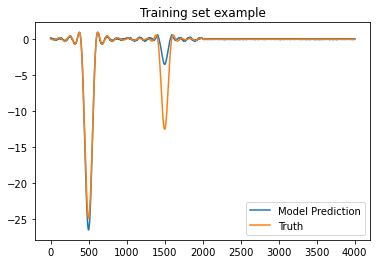

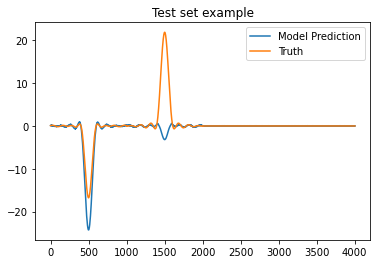

In [7]:
inp, tar = next(iter(train_dataloader)) 
print(inp)
plt.figure()
plt.title('Training set example')
plt.plot(model(inp).flatten().detach(),label = 'Model Prediction')
plt.plot(tar.flatten(),label ='Truth')
plt.legend()

inp, tar = next(iter(test_dataloader)) 
plt.figure()
plt.title('Test set example')
plt.plot(model(inp).flatten().detach(),label = 'Model Prediction')
plt.plot(tar.flatten(),label = 'Truth')
plt.legend()

In [8]:
## Test overfitting
EPOCHS = int(2e3)

overFitModel = DirectFeedForwardNet(in_features = 3,out_features = 4004,NN = 100)
optimizer = torch.optim.SGD(overFitModel.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
inp, tar = next(iter(train_dataloader)) 
for epoch in range(EPOCHS):
    prediction = overFitModel(inp)
        
    loss = criterion(input = prediction, target = tar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%(EPOCHS/10) == 0:
        print('Loss', loss.item())
    
    
plt.plot(overFitModel(inp).flatten().detach())
plt.plot(tar.flatten())

NameError: name 'MOMENTUM' is not defined

In [ ]:
inputs, classes = next(iter(train_dataloader)) 
print(inputs,classes)